# Proyecto 2 – Parte II (Core)
## Proyecto 2: Análisis y Selección de Problema

## Parte II: Preprocesamiento y Optimización

## Parte 1: Preprocesamiento de Datos :

In [17]:
!pip install lightgbm optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.2 MB/s eta 0:00:00


In [45]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

### Dataset Seleccionado: Dataset N°1

In [ ]:


df_pg = sns.load_dataset("penguins")
df_pg.info()

df_pg[df_pg["sex"].isna()]
df_pg[df_pg["species"].isna()]
df_pg[df_pg["island"].isna()]

df_pg.head()

df_pg[df_pg["sex"].isna()]

df_pg.groupby(["species", "island"])["sex"].value_counts()

#Especie  Adelie Isla Dream  hay más Male asíque completaré los Nan con Male
#Especie  Gentoo Isla Biscoe  hay más Male asíque completaré los Nan con Male
df_pg.loc[(df_pg["island"].isin(["Dream", "Biscoe"])) & (df_pg["sex"].isna()),"sex"] = "Male"

#Especie  Adelie Isla Torgersen hay más Female asíque completaré los Nan con Female
df_pg.loc[(df_pg["species"].isin(["Adelie"])) & (df_pg["island"].isin(["Torgersen"])) &  (df_pg["sex"].isna()), "sex"] = "Female"


df_pg["sex"].value_counts()
df_pg.info()

df_pg[ df_pg["bill_length_mm"].isna() &    df_pg["bill_depth_mm"].isna() &    df_pg["flipper_length_mm"].isna() &    df_pg["body_mass_g"].isna()].shape

df_pg = df_pg.drop( df_pg[df_pg["bill_length_mm"].isna() & df_pg["bill_depth_mm"].isna() & df_pg["flipper_length_mm"].isna() & df_pg["body_mass_g"].isna() ].index)

df_pg.describe().T

df_pg.duplicated().sum()

Modelo seleccionado: LGBMClassifier   
Dataset N°1 : Pingüinos ---> target: species (categoria)  ---> clasificador  

In [20]:
# Division de features y target.
X_pg = df_pg.drop(columns="species")
#y = df["species_target"]
y_pg = df_pg["species"] #el modelo de arbol si entiende el target en string

In [21]:
# Split.
X_train_pg, X_test_pg, y_train_pg, y_test_pg = train_test_split(X_pg, y_pg, test_size=0.2)

In [16]:
# preprocesamiento
# Dividir features.
num_cols_pg = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"] #features numericas
#ord_cols = ["class", "alone"] #features ordinales
nom_cols_pg = ["sex", "island"] #features nominales

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols_pg),
    ("nom", OneHotEncoder(handle_unknown='ignore'), nom_cols_pg)
])

In [28]:
# Optuna
def objective_pg(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 30)
    }

    model = Pipeline([
        ("pre", preprocessor),
        ("lgbm", LGBMClassifier(random_state=42, **params)) #modelo de clasificación
    ])

    score = cross_val_score(model, X_train_pg, y_train_pg, cv=3, scoring="accuracy", n_jobs=-1)
    return score.mean()

study_clf = optuna.create_study(direction="maximize")
study_clf.optimize(objective_pg, n_trials=20)
optuna_bparams = study_clf.best_params

print("Mejores hiperparámetros (clasificación):", optuna_bparams)

[I 2025-07-15 20:28:42,493] A new study created in memory with name: no-name-8edb9954-c1f8-48b0-a82c-de0dddee2b0b
[I 2025-07-15 20:28:50,102] Trial 0 finished with value: 0.9963369963369964 and parameters: {'n_estimators': 182, 'max_depth': 10}. Best is trial 0 with value: 0.9963369963369964.
[I 2025-07-15 20:28:50,648] Trial 1 finished with value: 0.9963369963369964 and parameters: {'n_estimators': 360, 'max_depth': 9}. Best is trial 0 with value: 0.9963369963369964.
[I 2025-07-15 20:28:51,358] Trial 2 finished with value: 0.9963369963369964 and parameters: {'n_estimators': 447, 'max_depth': 6}. Best is trial 0 with value: 0.9963369963369964.
[I 2025-07-15 20:28:51,630] Trial 3 finished with value: 0.989010989010989 and parameters: {'n_estimators': 70, 'max_depth': 27}. Best is trial 0 with value: 0.9963369963369964.
[I 2025-07-15 20:28:52,019] Trial 4 finished with value: 0.9963369963369964 and parameters: {'n_estimators': 194, 'max_depth': 24}. Best is trial 0 with value: 0.99633699

Mejores hiperparámetros (clasificación): {'n_estimators': 182, 'max_depth': 10}


In [ ]:
# Pipeline.
model_pg = Pipeline([
        ("pp", preprocessor),
        ("model", LGBMClassifier(random_state=42, **optuna_bparams))
    ])

# Entrenamiento.
model_pg.fit(X_train_pg, y_train_pg)

# Prediccion.
y_pred_pg = model_pg.predict(X_test_pg)

In [35]:
# Evaluacion.
accuracy_pg = accuracy_score(y_test_pg, y_pred_pg)
accuracy_pg

1.0

El accuracy de 1.0 indica que puede haber un sobre ajuste

In [36]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 10]
}

grid_search = GridSearchCV(model_pg, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_pg, y_train_pg)

In [43]:
y_pred_gridsearch_pg = model_pg.predict(X_test_pg)
accuracy_pg = accuracy_score(y_test_pg, y_pred_gridsearch_pg)
accuracy_pg

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1.0

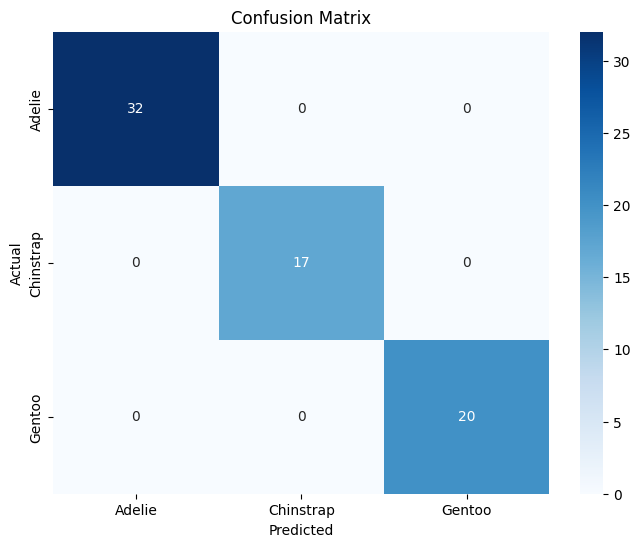

In [46]:
cm = confusion_matrix(y_test_pg, y_pred_gridsearch_pg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model_pg.classes_, yticklabels=model_pg.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()